# Assignment 6: Harmonic model


### Relevant Concepts

__Harmonic model parameters:__ The Harmonic model is used for the analysis of harmonic sounds. The file `harmonicModel.py` provides the code for Harmonic model analysis and synthesis. The key component of the harmonic model is the estimation of the fundamental frequency ($f_0$) and its harmonics. Apart from parameters that have been covered in previous exercises, such as the window, FFT size or the peak picking threshold, we have a few additional parameters used by the harmonic model.

1. `nH`: maximum number of harmonics to be used in the analysis.
2. `maxf0`: maximum $f_0$ frequency in Hz to be considered.
3. `minf0`: minimum $f_0$ frequency in Hz to be considered. Setting the `maxf0` and `minf0` accurately help to narrow down the $f_0$ candidates used by TWM algorithm and lead to better $f_0$ estimation.
4. `f0et`: error threshold in the $f_0$ detection. This is the maximum error allowed in the TWM algorithm. If the TWM mismatch error is larger than `f0et`, no $f_0$ is detected and the TWM algorithm returns $f_0 = 0$ for the frame.
5. `harmDevSlope`: slope of harmonic deviation allowed in the estimated harmonic frequency, compared to a perfect harmonic frequency. This is used to compute the threshold to generate the harmonics.

__Melody representation:__ For computational analysis, melody is represented typically by the pitch (fundamental frequency). The fundamental frequency ($f_0$) is usually estimated in $Hz$ but for a musically meaningful representation, we convert $f_0$ from Hz to Cents. Cent is a logarithmic scale computed as

\begin{align}
f_{0,\mathrm{Cents}}=1200\log_{2}\left(\frac{f_{0,\mathrm{Hz}}}{55.0}\right)
\end{align}

Assuming a tuning frequency of A4 = 440 Hz, the reference frequency used in the Cent scale is the frequency of the note A1 = 55Hz, i.e. 55Hz = 0 Cent.

__Segmentation and transcription:__
Audio segmentation and transcription are two important music information retrieval tasks. Audio segmentation aims to segment the audio into musically meaningful entities. Music Transcription aims to automatically obtain a score-like representation from a music audio piece. Segmentation is often a preprocessing step in transcription. Both these tasks have several different approaches that have been explored.

In this exercise, we will consider a simple approach to note level segmentation of melodies. Given the audio file, we first estimate the pitch (fundamental frequency $f_0$) for the whole file. We then segment the pitch contour into stable regions. The stable regions most likely correspond to notes of the melody. We then have the start and end time stamps of each note played in the melody. A limitation of this approach to segmentation is that it might not work for notes with a vibrato.

You will only implement the segmentation as described above. However, additionally for each segment, given a tuning frequency (say A = 440 Hz), you can obtain the notes played in the melody by quantizing the pitch in each segment to a note - a note level transcription of the melody.

__Inharmonicity:__ In music, inharmonicity is the degree to which the frequencies of the partials depart from integer multiples of the fundamental frequency (harmonic series). An ideal, homogeneous, infinitesimally thin or infinitely flexible string or column of air has exactly harmonic modes of vibration. However, in any real musical instrument, the resonant body that produces the music tone - typically a string, wire, or column of air—deviates from this ideal and has some small or large amount of inharmonicity. You can read more about inharmonicity at http://en.wikipedia.org/wiki/Inharmonicity.

A typical example of an instrument that exhibits inharmonicity is the piano. For the piano, several models have been proposed to obtain the partials of the piano, which can be used to estimate the inharmonicity. One of the models proposed by Fletcher (Harvey Fletcher, "Normal Vibration Frequencies of a Stiff Piano String", J. Acoust. Soc. Am. 36, 203 (1964); http://dx.doi.org/10.1121/1.1918933) is shown in the following equation, where $f_r$ is the frequency of the $r^{\mathrm{th}}$ partial, $f_0$ is the fundamental frequency and $B$ is the inharmonicity coefficient.

\begin{align}
 f_r = rf_{0}\sqrt{(1+Br^{2})}
\end{align}

In this exercise, you will measure the inharmonicity in a piano note using the harmonic model. With the estimates of the fundamental frequency $f_0$ and of the harmonics $\mathbf{f}_{est}$ for a frame $l$, we can obtain a measure of inharmonicity as,

\begin{align}
I[l]=\frac{1}{R}\overset{R}{\underset{r=1}{\sum}}\left(\frac{\left|f_{\mathrm{est}}^{r}[l]-r\, f_{0}[l]\right|}{r}\right)
\end{align}

where $R$ is the number of harmonics (the number of harmonics being used to compute inharmonicity), $f_0[l]$ is the fundamental frequency estimated at the frame $l$ and $f_{\mathrm{est}}^{r}[l]$ is the estimated frequency of the $r^{\mathrm{th}}$ harmonic at the frame. Note that the first harmonic is the fundamental.

We can then compute the mean inharmonicity in a specific time region between the frame indexes $l_1$ and $l_2$ as,

\begin{align}
I_{\mathrm{mean}} = \frac{1}{l_2-l_1+1}\overset{l_2}{\underset{l=l_1}{\sum}}I[l]
\end{align}

__TWM algorithm candidate selection:__ The two way mismatch algorithm implemented in sms-tools needs a set of $f_0$ candidates to start with. An easy choice of candidates are the peaks of the magnitude spectrum within a specific range of frequencies. However, this way of choosing $f_0$ candidates fails when there is no peak corresponding to the true $f_0$ value. The generation of $f_0$ candidates can be done better by also including the sub-harmonics of the peak frequencies as $f_0$ candidates.

__Searching numpy arrays:__ Numpy provides an efficient way to search for a specific element(s) of an array that satisfy a given condition. You can use `np.where()` in such cases. e.g. Given a numpy array `a = array([ 0.9193727 ,  0.6359579 ,  0.8335968 ,  0.20568055,  0.13874869])` and you want to extract the indexes of elements less than 0.5, you can use `np.where(a<0.5)[0]`. The function returns `array([3, 4])` corresponding the indexes of the elements in `a` less than 0.5.

## Part 1 - Estimate one fundamental frequency in a polyphonic audio signal

Perform a good fundamental frequency estimation of one sound source within a simple polyphonic sound using the Two-way mismatch algorithm.

The sound is a cello recording `cello-double-2.wav`, in which two strings are played simultaneously. One string
plays a constant drone while the other string plays a simple melody. You have to choose the analysis parameter values such that the `f0` frequency of the simple melody is tracked.

The core function used is `f0Detection()`, part of the `harmonicModel.py` module, which in turn uses the Two-way mismatch algorithm. Of all possible analysis parameters we will focus on the following ones:

1. `window` (string): analysis window
2. `M` (integer): window size used for computing the spectrum
3. `N` (integer): FFT size used for computing the spectrum
4. `f0et` (float): error threshold used for the f0 computation
5. `t` (float): magnitude threshold in dB used in spectral peak picking
6. `minf0` (float): minimum fundamental frequency in Hz
7. `maxf0` (float): maximum fundamental frequency in Hz



In [1]:
import numpy as np
import math
from scipy.signal import get_window
import matplotlib.pyplot as plt
import IPython.display as ipd

from smstools.models import utilFunctions as UF
from smstools.models import harmonicModel as HM
from smstools.models import sineModel as SM
from smstools.models import stft
from smstools.models import dftModel as DFT

eps = np.finfo(float).eps

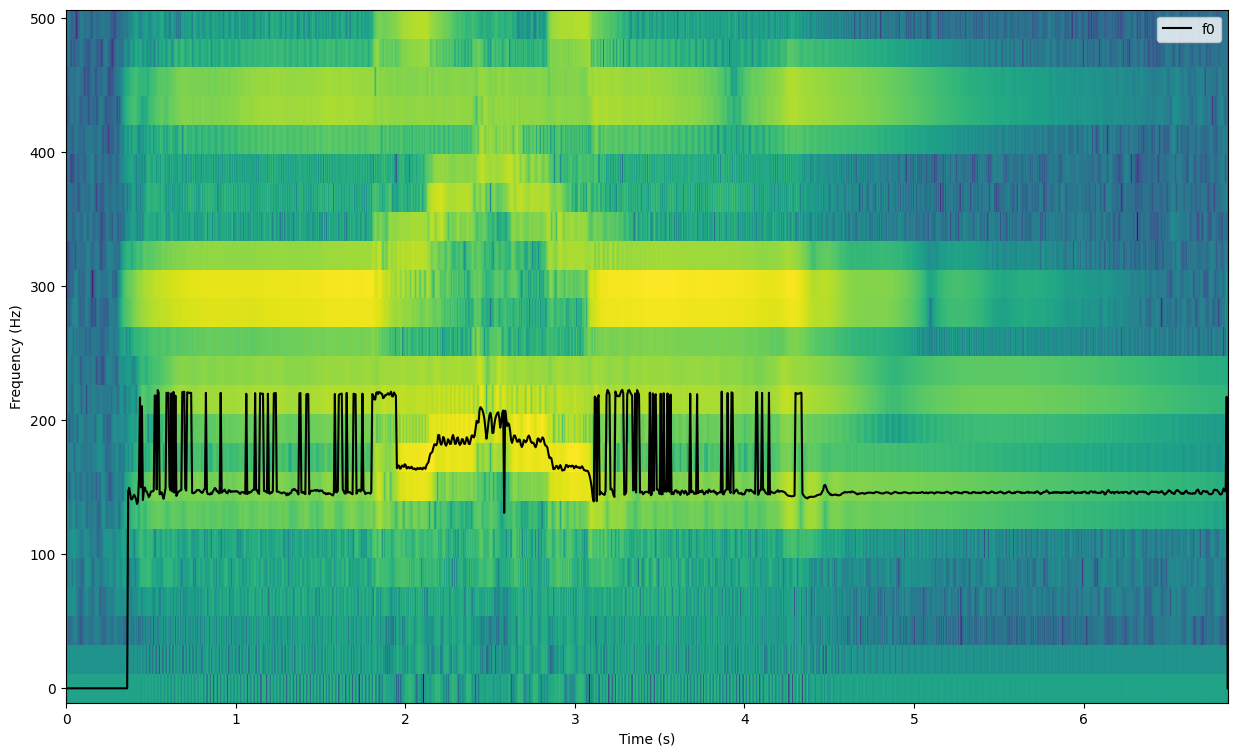

In [ ]:


input_file = 'cello-double-2.wav'

### Change these analysis parameter values marked as XX

window = 'hamming' 
M = 2048  
N = 2048  
f0et = 10 
t = -70 
minf0 = 100 
maxf0 = 250  


# No need to modify the code below, just understand it
H = 256
fs, x = UF.wavread(input_file)
w  = get_window(window, M)
f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)
y = UF.sinewaveSynth(f0, 0.8, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

# Code for plotting the f0 contour on top of the spectrogram
maxplotfreq = 500.0
fig = plt.figure(figsize=(15, 9))

mX, pX = stft.stftAnal(x, w, N, H)
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])

timeStamps = np.arange(mX.shape[1])*H/float(fs)
binFreqs = np.arange(mX.shape[0])*fs/float(N)

plt.pcolormesh(timeStamps, binFreqs, mX, shading='auto')
plt.plot(timeStamps, f0, color = 'k', linewidth=1.5)

plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.legend(('f0',))
plt.show()


The melody we want to track has gradual pitch changes rather than rapid transitions, making it more suitable to use a window that prioritizes frequency resolution over time resolution. For this reason, I chose the Hamming window, which provides a good balance by minimizing spectral leakage while maintaining adequate resolution.

Since our primary goal is to track the fundamental frequency (f0) of the melody rather than capturing transient or rapid note changes, both the window size (M) and FFT size (N) are set to 2048. This relatively high value enhances frequency resolution, which is crucial for accurately identifying the fundamental frequency.

Because the cello exhibits slight vibrato, I set the f0 estimation tolerance to 10 Hz. This allows for small, natural fluctuations in pitch without causing the algorithm to mistakenly identify them as separate notes or introduce errors in frequency tracking.

For the threshold, I selected -70 dB, which ensures that we effectively suppress background noise while still capturing relevant low-frequency components of the melody.

Finally, the minimum (minf0 = 100 Hz) and maximum (maxf0 = 400 Hz) fundamental frequencies were chosen based on spectrogram analysis. The fundamental frequencies of the melody do not exceed 300 Hz and do not drop below 100 Hz, so this range ensures that the algorithm focuses only on the relevant frequencies while ignoring unwanted harmonics or extraneous low-frequency noise.


## Part 2 - Segmentation of stable frequency regions of an audio signal

The function `segment_stable_frequency_regions()` identifies the stable fundamental frequency regions of a given sound. The function returns the start and end frame indexes of each a stable region.

The arguments to the function are the fundamental frequency of a monophonic audio signal (`f0`), threshold to
be used for deciding stable notes (`stdThsld`) in cents, minimum allowed duration of a stable note (`minNoteDur`),
number of samples to be considered for computing standard deviation (`winStable`). The function returns a numpy array of `shape (k,2)`, where `k` is the total number of detected segments. The two columns in each row contains the starting and the ending frame indexes of a stable note segment. The segments are returned in the increasing order of their start times.


In [3]:
# function used in exercise

def segment_stable_frequency_regions(f0, stdThsld, minNoteDur, winStable):
    """Segment the stable regions of a fundamental frequency track.

    Args:
        f0 (np.array): f0 values of a sound
        stdThsld (float): threshold for detecting stable regions in the f0 contour (in cents)
        minNoteDur (float): minimum allowed segment length (note duration)
        winStable (int): number of samples used for computing standard deviation

    Result:
        segments (np.array): starting and ending frame indexes of every segment

    """

    # convert f0 values from Hz to Cents (as described in pdf document)
    f0Cents = 1200*np.log2((f0+eps)/55.0)

    # create an array containing standard deviation of last winStable samples
    stdArr = 10000000000*np.ones(f0.shape)
    for ii in range(winStable-1, len(f0)):
        stdArr[ii] = np.std(f0Cents[ii-winStable+1:ii+1])

    # apply threshold on standard deviation values to find indexes of the stable points in melody
    indFlat = np.where(stdArr<=stdThsld)[0]
    flatArr = np.zeros(f0.shape)
    flatArr[indFlat] = 1

    # create segments of continuous stable points such that consecutive stable points belong to same segment
    onset = np.where((flatArr[1:]-flatArr[:-1])==1)[0]+1
    offset = np.where((flatArr[1:]-flatArr[:-1])==-1)[0]

    # remove any offset before onset (to sync them)
    indRem = np.where(offset<onset[0])[0]
    offset = np.delete(offset, indRem)

    minN = min(onset.size, offset.size)
    segments = np.transpose(np.vstack((onset[:minN], offset[:minN])))

    # apply segment filtering, i.e. remove segments with are < minNoteDur in length
    minNoteSamples = int(np.ceil(minNoteDur*fs/H))
    diff = segments[:,1] - segments[:,0]
    indDel = np.where(diff<minNoteSamples)
    segments = np.delete(segments,indDel, axis=0)

    return segments

The number of segments is: 9


'\n\n'

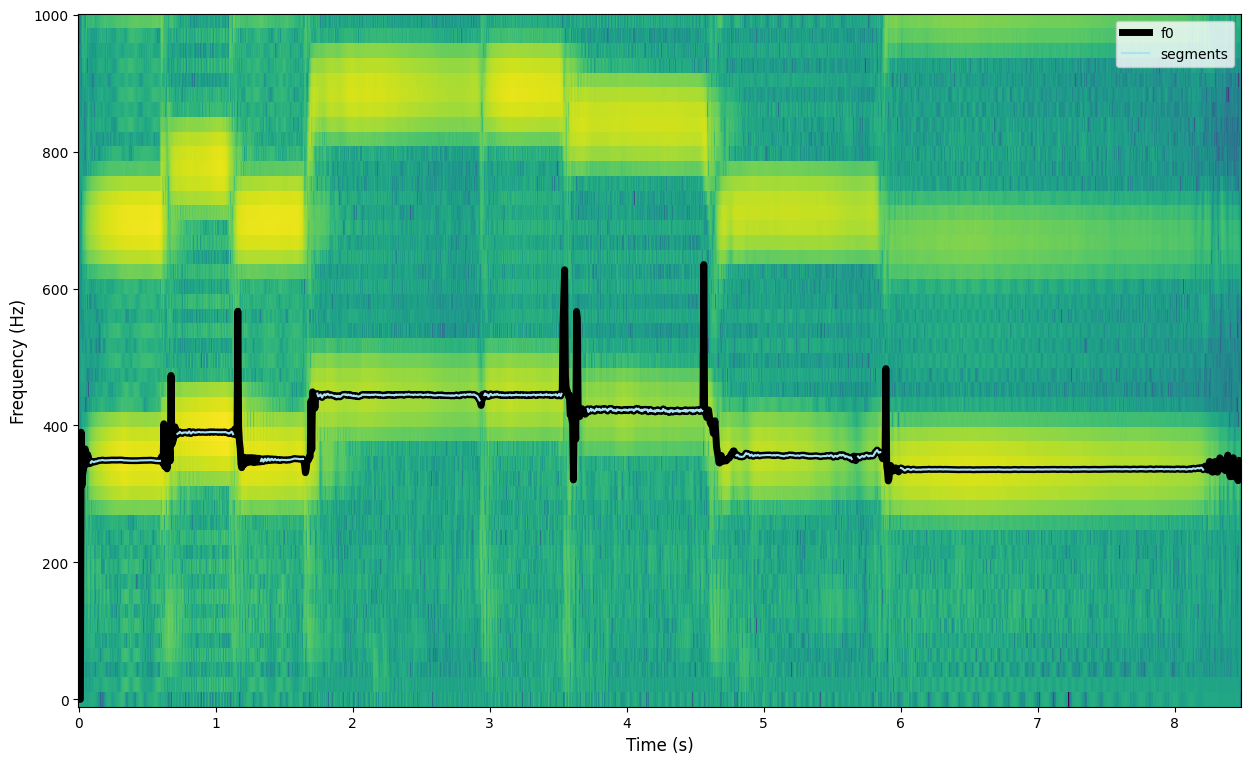

In [4]:

#TEST CASE 1
### parameters to change

input_file = 'cello-phrase.wav'
stdThsld = 10
minNoteDur = 0.1
winStable = 3
window = 'hamming'
M = 1025
N = 2048
H = 256
f0et = 5
t = -100
minf0 = 310
maxf0 = 650


# no need to change any code after here

# compute f0 and segments
fs, x = UF.wavread(input_file)
w  = get_window(window, M)
f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)
segments = segment_stable_frequency_regions(f0,stdThsld, minNoteDur,winStable)
print('The number of segments is:', len(segments))

# plot spectrogram, f0, and segments
maxplotfreq = 1000.0

plt.figure(figsize=(15, 9))

mX, pX = stft.stftAnal(x, w, N, H)
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])

timeStamps = np.arange(mX.shape[1])*H/float(fs)
binFreqs = np.arange(mX.shape[0])*fs/float(N)

plt.pcolormesh(timeStamps, binFreqs, mX, shading='auto')
plt.plot(timeStamps, f0, color = 'k', linewidth=5)

for i in range(segments.shape[0]):
    plt.plot(timeStamps[segments[i,0]:segments[i,1]], f0[segments[i,0]:segments[i,1]], color = '#A9E2F3', linewidth=1.5)
plt.ylabel('Frequency (Hz)', fontsize = 12)
plt.xlabel('Time (s)', fontsize = 12)
plt.legend(('f0','segments'))

### Explanation
"""

"""

The number of segments is: 6


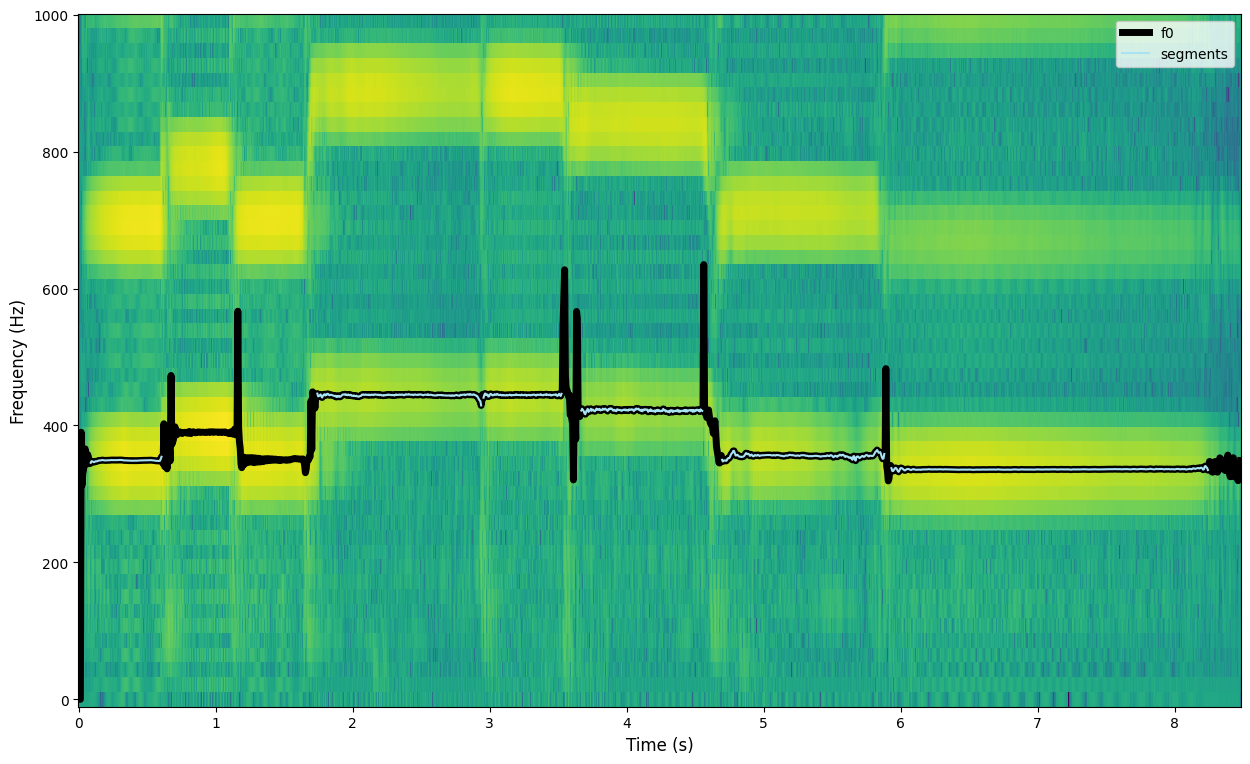

In [5]:
#TEST CASE 2
### parameters to change

input_file = 'cello-phrase.wav'
stdThsld = 20
minNoteDur = 0.5
winStable = 3
window = 'hamming'
M = 1025
N = 2048
H = 256
f0et = 5
t = -100
minf0 = 310
maxf0 = 650


# no need to change any code after here

# compute f0 and segments
fs, x = UF.wavread(input_file)
w  = get_window(window, M)
f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)
segments = segment_stable_frequency_regions(f0,stdThsld, minNoteDur,winStable)
print('The number of segments is:', len(segments))

# plot spectrogram, f0, and segments
maxplotfreq = 1000.0

plt.figure(figsize=(15, 9))

mX, pX = stft.stftAnal(x, w, N, H)
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])

timeStamps = np.arange(mX.shape[1])*H/float(fs)
binFreqs = np.arange(mX.shape[0])*fs/float(N)

plt.pcolormesh(timeStamps, binFreqs, mX, shading='auto')
plt.plot(timeStamps, f0, color = 'k', linewidth=5)

for i in range(segments.shape[0]):
    plt.plot(timeStamps[segments[i,0]:segments[i,1]], f0[segments[i,0]:segments[i,1]], color = '#A9E2F3', linewidth=1.5)
plt.ylabel('Frequency (Hz)', fontsize = 12)
plt.xlabel('Time (s)', fontsize = 12)
plt.legend(('f0','segments'))



The number of segments is: 1


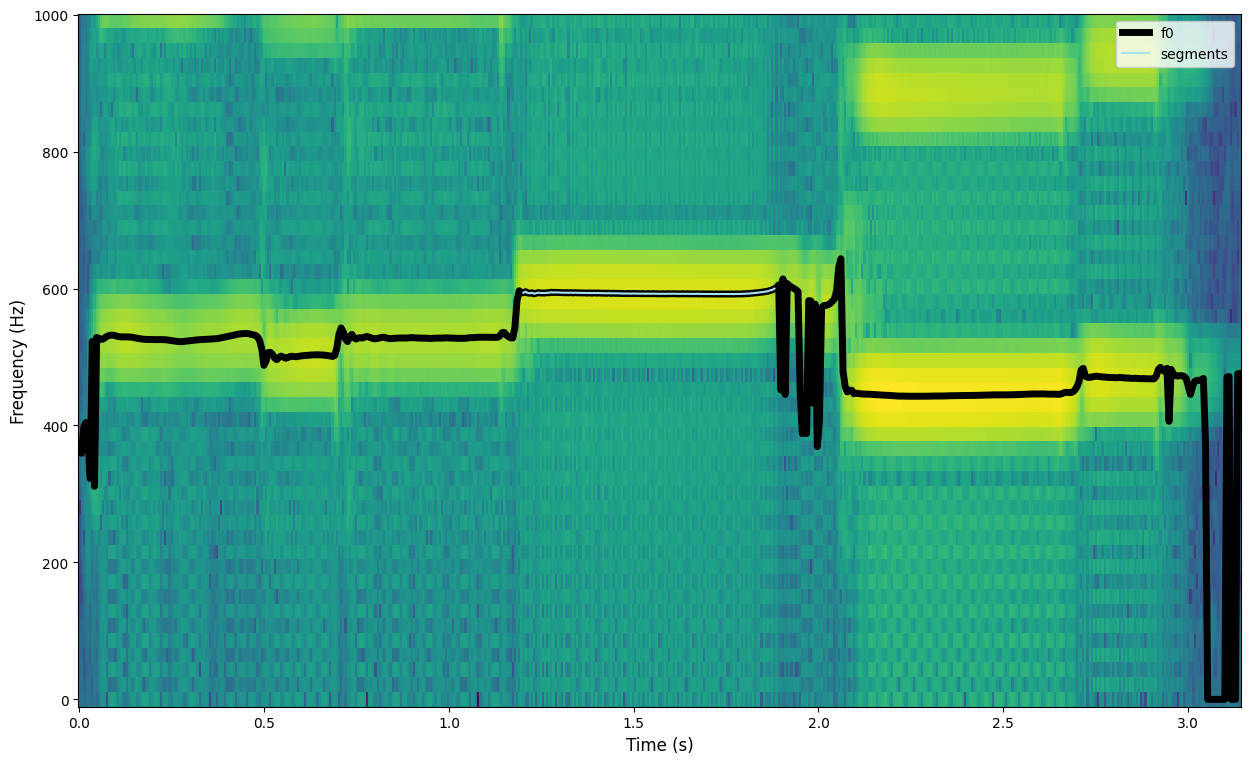

In [6]:
#TEST CASE 3
### parameters to change

input_file = 'sax-phrase-short.wav'
stdThsld = 5
minNoteDur = 0.6
winStable = 3
window = 'hamming'
M = 1025
N = 2048
H = 256
f0et = 5
t = -100
minf0 = 310
maxf0 = 650


# no need to change any code after here

# compute f0 and segments
fs, x = UF.wavread(input_file)
w  = get_window(window, M)
f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)
segments = segment_stable_frequency_regions(f0,stdThsld, minNoteDur,winStable)
print('The number of segments is:', len(segments))

# plot spectrogram, f0, and segments
maxplotfreq = 1000.0

plt.figure(figsize=(15, 9))

mX, pX = stft.stftAnal(x, w, N, H)
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])

timeStamps = np.arange(mX.shape[1])*H/float(fs)
binFreqs = np.arange(mX.shape[0])*fs/float(N)

plt.pcolormesh(timeStamps, binFreqs, mX, shading='auto')
plt.plot(timeStamps, f0, color = 'k', linewidth=5)

for i in range(segments.shape[0]):
    plt.plot(timeStamps[segments[i,0]:segments[i,1]], f0[segments[i,0]:segments[i,1]], color = '#A9E2F3', linewidth=1.5)
plt.ylabel('Frequency (Hz)', fontsize = 12)
plt.xlabel('Time (s)', fontsize = 12)
plt.legend(('f0','segments'))



The number of segments is: 6


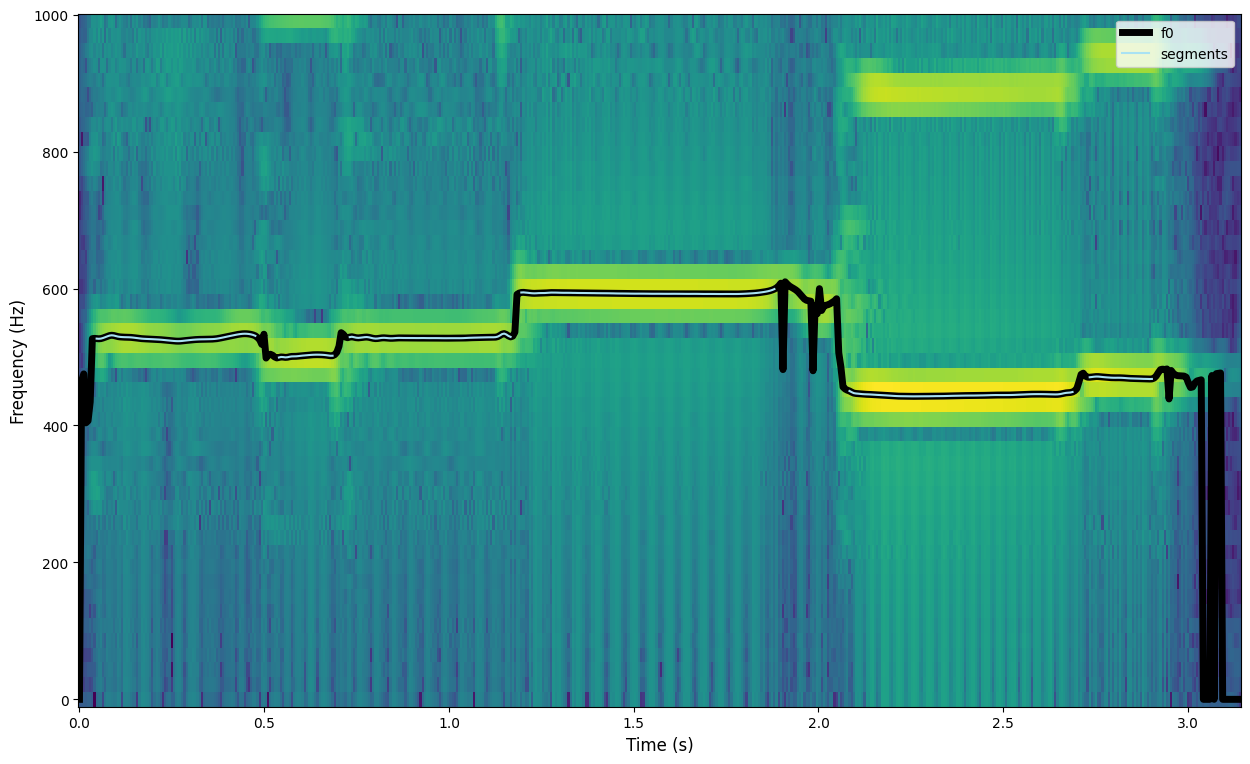

In [ ]:


### parameters to change

input_file = 'sax-phrase-short.wav'
stdThsld = 5
minNoteDur = 0.1
winStable = 3
window = 'hamming'
M = 2048
N = 2048
H = 256
f0et = 5
t = -100
minf0 = 400
maxf0 = 650


# no need to change any code after here

# compute f0 and segments
fs, x = UF.wavread(input_file)
w  = get_window(window, M)
f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)
segments = segment_stable_frequency_regions(f0,stdThsld, minNoteDur,winStable)
print('The number of segments is:', len(segments))

# plot spectrogram, f0, and segments
maxplotfreq = 1000.0

plt.figure(figsize=(15, 9))

mX, pX = stft.stftAnal(x, w, N, H)
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])

timeStamps = np.arange(mX.shape[1])*H/float(fs)
binFreqs = np.arange(mX.shape[0])*fs/float(N)

plt.pcolormesh(timeStamps, binFreqs, mX, shading='auto')
plt.plot(timeStamps, f0, color = 'k', linewidth=5)

for i in range(segments.shape[0]):
    plt.plot(timeStamps[segments[i,0]:segments[i,1]], f0[segments[i,0]:segments[i,1]], color = '#A9E2F3', linewidth=1.5)
plt.ylabel('Frequency (Hz)', fontsize = 12)
plt.xlabel('Time (s)', fontsize = 12)
plt.legend(('f0','segments'))





For the test case 1 the results show that the chosen threshold of 10 resulted in 9 detected stable frequency segments. This suggests that the system is highly sensitive to small fluctuations in the fundamental frequency. The short minimum note duration (0.1 seconds) likely allows for many brief stable regions to be included in the result. 

For the test cas 2, which have a higher threshold of 20, the function detected only 6 stable segments. This means the algorithm is more selective, only capturing longer or more stable regions in the frequency contour. The minimum note duration of 0.5 seconds also likely removed smaller, potentially less significant segments, helping to consolidate the segmentation into fewer notes.

For the test case 3, we have a very low threshold of 5 and a relatively long minimum note duration of 0.6 seconds, the function detected a single segment. This indicates that the audio signal is considered sufficiently stable over the entire duration, leading to the combination of multiple possible segments into one continuous note.

Between the test cases the other parameters remain the same. Important to note that we are working with a low M, and we are having a low frequency resolution, which influentiates the result.

To select the parameters for this analysis, I carefully examined the spectrogram of the saxophone phrase. From the spectrogram, I observed that the frequency fluctuations are relatively small, which led me to choose a low standard deviation threshold (stdThsld). This ensures that the algorithm can capture even the smallest changes in pitch.
Next, I set the minimum note duration (minNoteDur) based on the shortest note I observed in the spectrogram. Since there are brief notes in the phrase, I chose a very small value for winStable (window size for calculating standard deviation) to make the algorithm more sensitive to rapid frequency changes. 
I opted for a Hamming window for its well-known ability to minimize spectral leakage, offering a good balance between frequency resolution and minimizing side lobes. Since the saxophone has relatively small frequency fluctuations, I chose a larger FFT size (M = 2048) to improve frequency resolution.
For the hop size (H = 256), I selected a value that strikes a balance between temporal accuracy and computational efficiency. The fundamental frequency estimation threshold (f0et) is set low, meaning the algorithm will only accept frequency estimates that meet a relatively high confidence level.
I chose a time shift threshold (t = -100 cents) to ensure that the algorithm captures all frequency changes relevant to the melody, while filtering out minor noise or irrelevant shifts. Lastly, I set the minimum and maximum fundamental frequencies (minf0 = 400 Hz, maxf0 = 650 Hz) by inspecting the frequency range of the most energetic harmonics in the saxophone's notes. 

For the cello phrase, similar parameters were chosen, but some adjustments were made to better suit the characteristics of the instrument. The most notable change is the note duration, which is set longer for the cello since in this phrase the notes are more sustained compared to the faster, shorter notes of the saxophone. Additionally, the winStable parameter is increased, reflecting the fact that this audio of the cello has more sustained, gradual pitch changes, requiring a slightly larger window to capture stable regions effectively.

Another significant change is the minf0 and maxf0 values. These are set to lower frequencies for the cello, as it has a deeper pitch range compared to the saxophone. Specifically, in the piece "El cant dels ocells", the cello's lower pitch range is particularly evident.
The parameters ensure accurate note segmentation, but pauses can cause the same note to appear in separate segments. This distinction is useful for later processing, as it preserves natural breaks in phrasing, articulation, and rhythm, making the segmentation more musically meaningful.



The number of segments is: 8


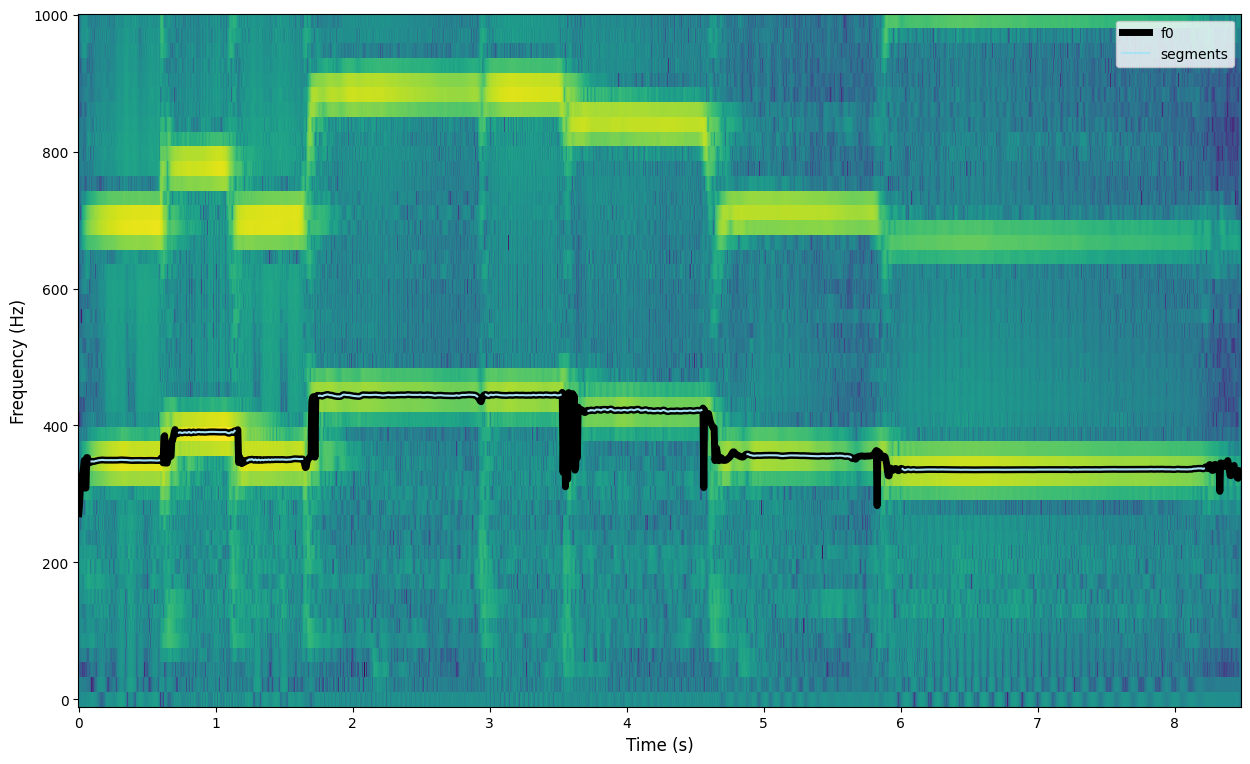

In [8]:
#CELLO
### parameters to change

input_file = 'cello-phrase.wav'
stdThsld = 5
minNoteDur = 0.3
winStable = 4
window = 'hamming'
M = 2048
N = 2048
H = 256
f0et = 5
t = -100
minf0 = 250
maxf0 = 450


# no need to change any code after here

# compute f0 and segments
fs, x = UF.wavread(input_file)
w  = get_window(window, M)
f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)
segments = segment_stable_frequency_regions(f0,stdThsld, minNoteDur,winStable)
print('The number of segments is:', len(segments))

# plot spectrogram, f0, and segments
maxplotfreq = 1000.0

plt.figure(figsize=(15, 9))

mX, pX = stft.stftAnal(x, w, N, H)
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])

timeStamps = np.arange(mX.shape[1])*H/float(fs)
binFreqs = np.arange(mX.shape[0])*fs/float(N)

plt.pcolormesh(timeStamps, binFreqs, mX, shading='auto')
plt.plot(timeStamps, f0, color = 'k', linewidth=5)

for i in range(segments.shape[0]):
    plt.plot(timeStamps[segments[i,0]:segments[i,1]], f0[segments[i,0]:segments[i,1]], color = '#A9E2F3', linewidth=1.5)
plt.ylabel('Frequency (Hz)', fontsize = 12)
plt.xlabel('Time (s)', fontsize = 12)
plt.legend(('f0','segments'))



## Part 3 - Compute amount of inharmonicity present in a sound

The function `estimate_inharmonicity()` measures the amount of inharmonicity present in a pitched/pseudo-harmonic sound. The function measures the mean inharmonicity from the harmonics obtained by a harmonic analysis. The input arguments are the harmonic frequencies and it return sthe mean inharmonicity value.

Use the formula given in the Relevant Concepts section above to compute the inharmonicity measure for the given interval. Note that for some frames some of the harmonics might not be detected due to their low energy. For handling such cases use only the detected harmonics (and set the value of `R` in the equation to the number of detected harmonics) to compute the inharmonicity measure. All the detected harmonics have a non-zero frequency.

In this question we will work with a piano sound (`'../sounds/piano.wav'`), a typical example of an instrument that exhibits inharmonicity (http://en.wikipedia.org/wiki/Piano_acoustics#Inharmonicity_and_piano_size).


In [ ]:


def estimate_inharmonicity(xhfreq):
    """Estimate inharmonicity factor from the psedo-harmonic frequencies of a sound.

    Args:
        xhfreq (np.array): harmonic frequencies of a sound

    Output:
        (float): mean inharmonicity over all the frames

    """
    inharmonicity_values = []
    
    # Loop through each frame in xhfreq
    for frame in xhfreq:
        # Ignore frames where no harmonics are detected
        if np.all(frame == 0):
            continue
        
        # Fundamental frequency (the first harmonic)
        f0 = frame[0]
        
        # Compute inharmonicity for this frame
        R = len(frame)  # Number of harmonics detected
        inharmonicity_sum = 0
        
        for r in range(1, R + 1):  # We use r from 1 to R
            f_est_r = frame[r - 1]
            if f_est_r != 0:  # If the harmonic is detected
                inharmonicity_sum += abs(f_est_r - r * f0) / r
        
        # Compute inharmonicity for this frame
        I_frame = inharmonicity_sum / R
        inharmonicity_values.append(I_frame)
    
    # Compute the mean inharmonicity
    if len(inharmonicity_values) > 0:
        I_mean = np.mean(inharmonicity_values)
    else:
        I_mean = 0  # If no frames had detected harmonics, inharmonicity is 0
    
    return I_mean


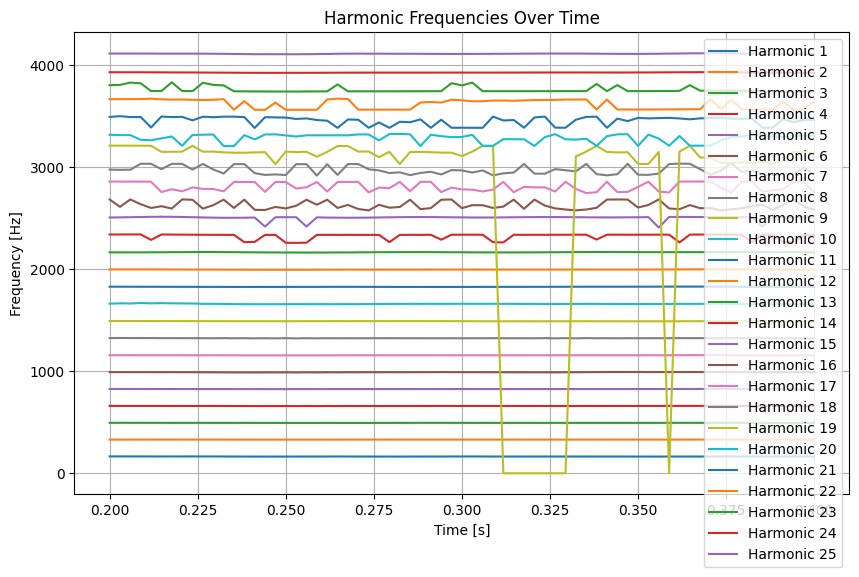

Mean Inharmonicity: 1.4467


In [ ]:


# Parameters
input_file = 'piano.wav'
fs, x = UF.wavread(input_file)
t1, t2 = 0.2, 0.4  # Time range to analyze
window = 'hamming'
M, N, H = 2047, 2048, 128
w = get_window(window, M)
f0et = 5.0
t = -90
minf0 = 130
maxf0 = 180
nH = 25

# Harmonic analysis returns harmonic frequencies for each frame
xhfreq, xhmag, xhphase = HM.harmonicModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope=0.01, minSineDur=0.02)

# Select the frames corresponding to the time range t1 to t2
frame_indices = range(int(t1 * fs / H), int(t2 * fs / H))  # Indices of frames within the time range
selected_xhfreq = xhfreq[frame_indices]  # Select the frames within the time range

time_vector = np.linspace(t1, t2, len(frame_indices))
# Plot harmonic frequencies for the selected frames
plt.figure(figsize=(10, 6))

for harmonic in range(nH):
    harmonic_freqs = selected_xhfreq[:, harmonic]  # Harmonic frequencies for each frame
    plt.plot(time_vector, harmonic_freqs, label=f'Harmonic {harmonic + 1}')

# Adding labels and title
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Harmonic Frequencies Over Time')
plt.legend(loc='upper right')


plt.grid(True)
plt.show()

# Now, call estimate_inharmonicity to calculate the mean inharmonicity
mean_inharmonicity = estimate_inharmonicity(selected_xhfreq)

# Print the result to compare with the expected output
print(f"Mean Inharmonicity: {mean_inharmonicity:.4f}")


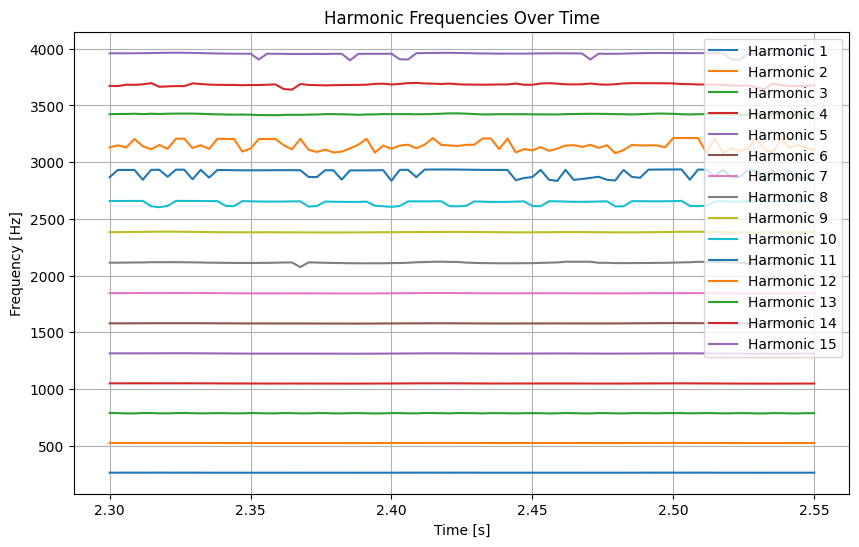

Mean Inharmonicity: 1.483288671036633


In [11]:
# TEST CASE 2
input_file = 'piano.wav'
fs, x = UF.wavread(input_file)

t1, t2 = 2.3, 2.55

M, N, H = 2047, 2048, 128
w = get_window('hamming', M)

f0et = 5.0
t = -90

minf0 = 230
maxf0 = 290

nH = 15

# Harmonic analysis returns harmonic frequencies, magnitudes, and phases
xhfreq, xhmag, xhphase = HM.harmonicModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et)

# Now, select the frames within the time range [t1, t2]
frame_indices = range(int(t1 * fs / H), int(t2 * fs / H))  # Indices of frames within the time range
selected_xhfreq = xhfreq[frame_indices]  # Select the frames within the time range

time_vector = np.linspace(t1, t2, len(frame_indices))
# Plot harmonic frequencies for the selected frames
plt.figure(figsize=(10, 6))

for harmonic in range(nH):
    harmonic_freqs = selected_xhfreq[:, harmonic]  # Harmonic frequencies for each frame
    plt.plot(time_vector, harmonic_freqs, label=f'Harmonic {harmonic + 1}')

# Adding labels and title
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Harmonic Frequencies Over Time')
plt.legend(loc='upper right')


plt.grid(True)
plt.show()

# Call estimate_inharmonicity to calculate the mean inharmonicity
mean_inharmonicity = estimate_inharmonicity(selected_xhfreq)

# Print the result to compare with the expected output
print(f"Mean Inharmonicity: {mean_inharmonicity:}")


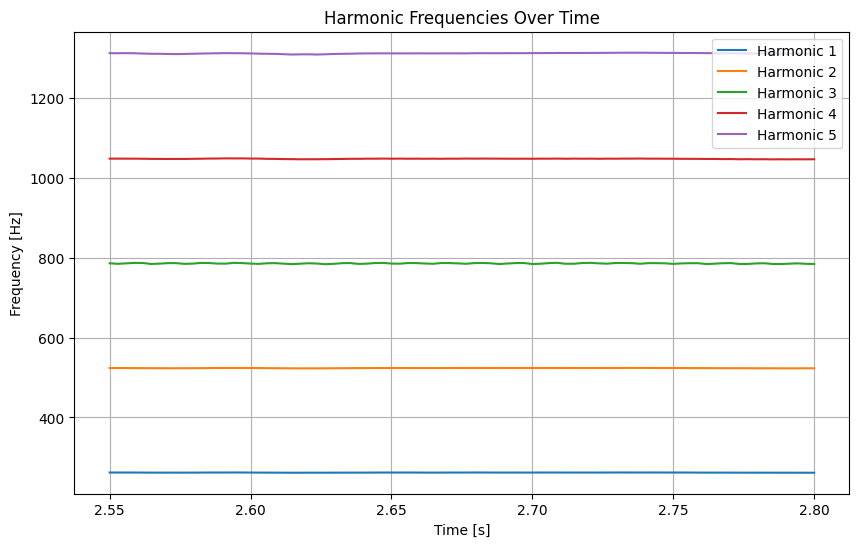

Mean Inharmonicity: 0.17382884564703646


In [12]:
# TEST CASE 3
input_file = 'piano.wav'
fs, x = UF.wavread(input_file)

t1, t2 = 2.55, 2.8

M, N, H = 2047, 2048, 128
w = get_window('hamming', M)

f0et = 5.0
t = -90

minf0 = 230
maxf0 = 290

nH = 5

# Harmonic analysis returns harmonic frequencies, magnitudes, and phases
xhfreq, xhmag, xhphase = HM.harmonicModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et)

# Now, select the frames within the time range [t1, t2]
frame_indices = range(int(t1 * fs / H), int(t2 * fs / H))  # Indices of frames within the time range
selected_xhfreq = xhfreq[frame_indices]  # Select the frames within the time range

time_vector = np.linspace(t1, t2, len(frame_indices))
# Plot harmonic frequencies for the selected frames
plt.figure(figsize=(10, 6))

for harmonic in range(nH):
    harmonic_freqs = selected_xhfreq[:, harmonic]  # Harmonic frequencies for each frame
    plt.plot(time_vector, harmonic_freqs, label=f'Harmonic {harmonic + 1}')

# Adding labels and title
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Harmonic Frequencies Over Time')
plt.legend(loc='upper right')

plt.grid(True)
plt.show()

# Call estimate_inharmonicity to calculate the mean inharmonicity
mean_inharmonicity = estimate_inharmonicity(selected_xhfreq)

# Print the result to compare with the expected output
print(f"Mean Inharmonicity: {mean_inharmonicity:}")




From what we know, the inharmonicity present in the piano is due to its physical characteristics, as described by the Railsback curve. This means that lower and higher notes tend to be more inharmonic, while mid-range notes remain more harmonic. 

In the first plot, where we analyze 25 harmonics, we can observe that from 0 to around 2000 Hz, the harmonics remain perfectly harmonic. This is because the note being analyzed is from the mid-range, where the first harmonics are well-defined. However, beyond 2000 Hz, the harmonics start to become less defined (as seen in the spectrogram of the sound), introducing more inharmonicity. Additionally, harmonics above 4000 Hz appear to be artificially reconstructed by the algorithm rather than being actual harmonics present in the spectrogram.

In the second and third plots, we observe less inharmonicity because we are considering fewer harmonics, and the ones included are more energetic so more well-defined. In the second plot, the higher harmonics still exhibit some degree of inharmonicity, while in the third plot, where even fewer harmonics are considered, the inharmonicity is almost negligible.

Initially, when applying the same parameters used for the piano to a cello phrase, the results were inconclusive. In many cases, harmonics were not detected because the algorithm was considering wrong parameters. This led to incorrect results.

Changing the parameter we can see that the cello’s harmonic plot is more stable because its harmonics are continuously reinforced by the bow and its long strings allow for more consistent spacing of overtones. However, due to string stiffness, all overtones are slightly stretched, leading to a higher mean inharmonicity.

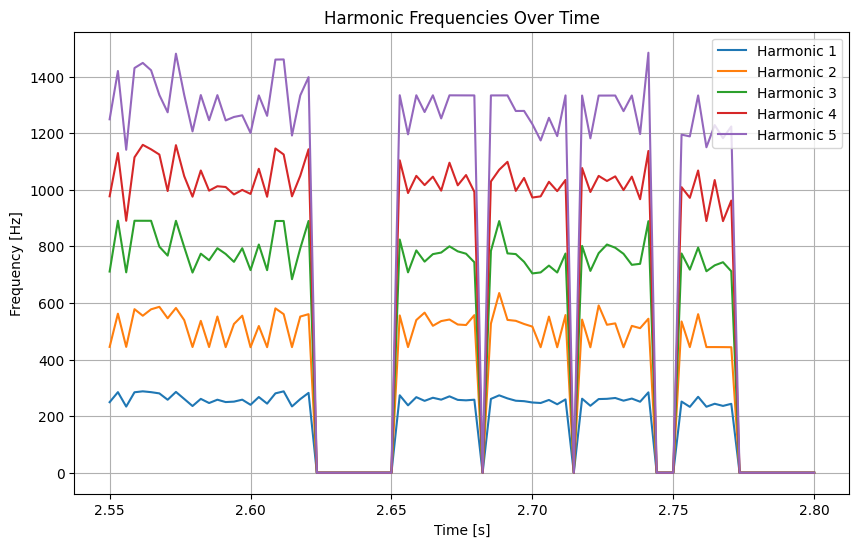

Mean Inharmonicity: 5.932806873517602


In [13]:
# TEST CASE 3 - CELLO
input_file = 'cello-phrase.wav'
fs, x = UF.wavread(input_file)

t1, t2 = 2.55, 2.8

M, N, H = 2048, 2048, 128
w = get_window('hamming', M)

f0et = 5.0
t = -90

minf0 = 230
maxf0 = 290

nH = 5

# Harmonic analysis returns harmonic frequencies, magnitudes, and phases
xhfreq, xhmag, xhphase = HM.harmonicModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et)

# Now, select the frames within the time range [t1, t2]
frame_indices = range(int(t1 * fs / H), int(t2 * fs / H))  # Indices of frames within the time range
selected_xhfreq = xhfreq[frame_indices]  # Select the frames within the time range

time_vector = np.linspace(t1, t2, len(frame_indices))
# Plot harmonic frequencies for the selected frames
plt.figure(figsize=(10, 6))

for harmonic in range(nH):
    harmonic_freqs = selected_xhfreq[:, harmonic]  # Harmonic frequencies for each frame
    plt.plot(time_vector, harmonic_freqs, label=f'Harmonic {harmonic + 1}')

# Adding labels and title
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Harmonic Frequencies Over Time')
plt.legend(loc='upper right')


plt.grid(True)
plt.show()

# Call estimate_inharmonicity to calculate the mean inharmonicity
mean_inharmonicity = estimate_inharmonicity(selected_xhfreq)

# Print the result to compare with the expected output
print(f"Mean Inharmonicity: {mean_inharmonicity:}")


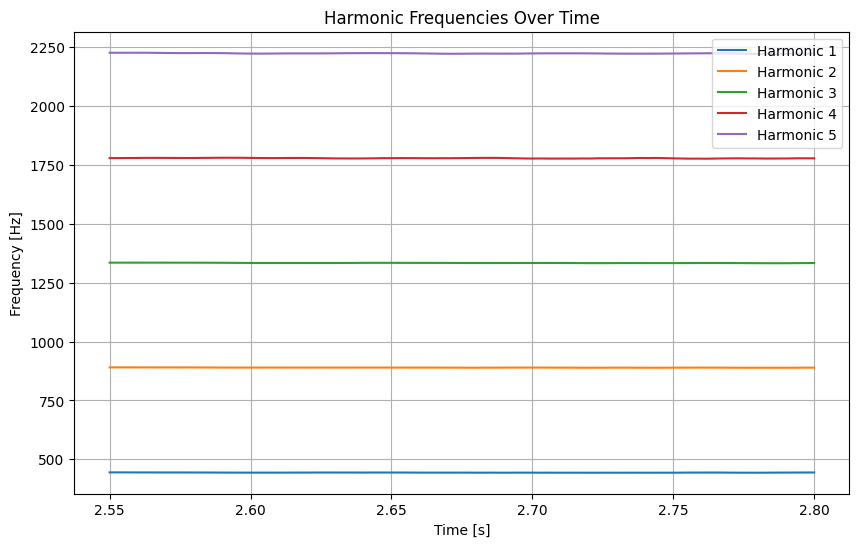

Mean Inharmonicity: 0.6179006800219866


In [14]:
# TEST CASE - CELLO - different paramters than the one purposed.
input_file = 'cello-phrase.wav'
fs, x = UF.wavread(input_file)

t1, t2 = 2.55, 2.8

M, N, H = 2048, 2048, 128
w = get_window('hamming', M)

f0et = 5.0
t = -80

minf0 = 400
maxf0 = 600

nH = 5

# Harmonic analysis returns harmonic frequencies, magnitudes, and phases
xhfreq, xhmag, xhphase = HM.harmonicModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et)

# Now, select the frames within the time range [t1, t2]
frame_indices = range(int(t1 * fs / H), int(t2 * fs / H))  # Indices of frames within the time range
selected_xhfreq = xhfreq[frame_indices]  # Select the frames within the time range

time_vector = np.linspace(t1, t2, len(frame_indices))
# Plot harmonic frequencies for the selected frames
plt.figure(figsize=(10, 6))

for harmonic in range(nH):
    harmonic_freqs = selected_xhfreq[:, harmonic]  # Harmonic frequencies for each frame
    plt.plot(time_vector, harmonic_freqs, label=f'Harmonic {harmonic + 1}')

# Adding labels and title
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Harmonic Frequencies Over Time')
plt.legend(loc='upper right')


plt.grid(True)
plt.show()

# Call estimate_inharmonicity to calculate the mean inharmonicity
mean_inharmonicity = estimate_inharmonicity(selected_xhfreq)

# Print the result to compare with the expected output
print(f"Mean Inharmonicity: {mean_inharmonicity:}")


## Part 4 - Improving the implementation of the two way mismatch f0 estimation algorithm

In this part I will try to improve the implementation of the two way mismatch algorithm used for fundamental frequency estimation. The main purpose of this part is to understand the limitations of the current implementation of the TWM algorithm.

I will do it by by directly modifying the core functions that implement the TWM algorithm 


1) Missing fundamental frequency: For many sounds the fundamental frequency component is very low and therefore during the spectral peak picking step we do not obtain any peak corresponding to the `f0`. Since the TWM algorithm implemented in sms-tools considers only the detected spectral peaks as the `f0` candidates, we do not get any candidate corresponding to the `f0`. This causes `f0` estimation to fail. For example, such a scenario is encountered in low pitched vocal sounds.
2) Pseudo-harmonicity in the sound: Many instruments, such as piano, exhibit some deviation from perfect harmonicity wherein their harmonic partials are not perfectly located at integral multiples of the fundamental frequency. Since the TWM algorithm computes error function assuming that the harmonic locations are at integral multiples, its performance is poorer when such deviations exist.

In this question we propose to work on these two scenarios. Go to freesound and download sound examples of low pitched vocal sounds and of piano. Run current implementation of TMW to identify the limitations and propose improvements to the code in order to obtain better `f0` estimation for those two particular scenarios.

The core TWM algorithm is implemented in the function `TWM_p()`, which takes in an array of `f0` candidates and detect the candidate that has the lowest error. `TWM_p()` is called by `f0Twm()`, which generates `f0` candidates `(f0c = np.argwhere((pfreq>minf0) & (pfreq<maxf0))[:,0])`. This function also implements a memory based prunning of the `f0` candidates. If the `f0` contour is found to be stable (no drastic transitions across frames) then only the `f0` candidates close to the stable `f0` value are retained. `f0Twm()` is called for every audio frame by `f0Detection()`.




In [15]:
def smooth_f0(f0, window_size=5):
    """
    Apply a moving average filter to smooth the f0 estimates.
    """
    return np.convolve(f0, np.ones(window_size) / window_size, mode='same')

In [16]:
### modify anything in f0Detection()
def f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et):
    """
    Fundamental frequency detection of a sound using twm algorithm
    x: input sound; fs: sampling rate; w: analysis window;
    N: FFT size; t: threshold in negative dB,
    minf0: minimum f0 frequency in Hz, maxf0: maximim f0 frequency in Hz,
    f0et: error threshold in the f0 detection (ex: 5),
    returns f0: fundamental frequency
    """
    if (minf0 < 0):                                            # raise exception if minf0 is smaller than 0
        raise ValueError("Minumum fundamental frequency (minf0) smaller than 0")

    if (maxf0 >= 10000):                                       # raise exception if maxf0 is bigger than fs/2
        raise ValueError("Maximum fundamental frequency (maxf0) bigger than 10000Hz")

    if (H <= 0):                                               # raise error if hop size 0 or negative
        raise ValueError("Hop size (H) smaller or equal to 0")

    hN = N/2                                                   # size of positive spectrum
    hM1 = int(math.floor((w.size+1)/2))                        # half analysis window size by rounding
    hM2 = int(math.floor(w.size/2))                            # half analysis window size by floor
    x = np.append(np.zeros(hM2),x)                             # add zeros at beginning to center first window at sample 0
    x = np.append(x,np.zeros(hM1))                             # add zeros at the end to analyze last sample
    pin = hM1                                                  # init sound pointer in middle of anal window
    pend = x.size - hM1                                        # last sample to start a frame
    fftbuffer = np.zeros(N)                                    # initialize buffer for FFT
    w = w / sum(w)                                             # normalize analysis window
    f0 = []                                                    # initialize f0 output
    f0t = 0                                                    # initialize f0 track
    f0stable = 0                                               # initialize f0 stable
    while pin<pend:
        x1 = x[pin-hM1:pin+hM2]                                  # select frame
        mX, pX = DFT.dftAnal(x1, w, N)                           # compute dft
        ploc = UF.peakDetection(mX, t)                           # detect peak locations
        iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)      # refine peak values
        ipfreq = fs * iploc/N                                    # convert locations to Hez

        harmonic_candidates = []
        for i in range(len(ipfreq)):
            f0_candidate = ipfreq[i]
            # Generate harmonics by considering integer multiples of the peaks
            for harmonic in range(2, 7):  # Consider harmonics up to the 5th
                harmonic_freq = f0_candidate * harmonic
                if minf0 <= harmonic_freq <= maxf0:
                    harmonic_candidates.append(harmonic_freq)
        
        # Combine original peaks and harmonic candidates
        combined_candidates = np.concatenate([ipfreq, harmonic_candidates])
        combined_candidates = combined_candidates[:len(ipfreq)]

        
        f0t = f0Twm(combined_candidates, ipmag, f0et, minf0, maxf0, f0stable)  # find f0
        if ((f0stable==0)&(f0t>0)) \
                or ((f0stable>0)&(np.abs(f0stable-f0t)<f0stable/5.0)):
            f0stable = f0t                                         # consider a stable f0 if it is close to the previous one
        else:
            f0stable = 0
        f0 = np.append(f0, f0t)                                  # add f0 to output array
        pin += H  
        
    f0 = smooth_f0(f0, window_size=5)                                                # advance sound pointer
    return f0

In [17]:
### modify anything in f0Twm()
def f0Twm(pfreq, pmag, ef0max, minf0, maxf0, f0t=0):
    """
    Function that wraps the f0 detection function TWM, selecting the possible f0 candidates
    and calling the function TWM with them
    pfreq, pmag: peak frequencies and magnitudes,
    ef0max: maximum error allowed, minf0, maxf0: minimum  and maximum f0
    f0t: f0 of previous frame if stable
    returns f0: fundamental frequency in Hz
    """
    if (minf0 < 0):                                  # raise exception if minf0 is smaller than 0
        raise ValueError("Minumum fundamental frequency (minf0) smaller than 0")

    if (maxf0 >= 10000):                             # raise exception if maxf0 is bigger than 10000Hz
        raise ValueError("Maximum fundamental frequency (maxf0) bigger than 10000Hz")

    if (pfreq.size < 3) & (f0t == 0):                # return 0 if less than 3 peaks and not previous f0
        return 0

    f0c = np.argwhere((pfreq>minf0) & (pfreq<maxf0))[:,0] # use only peaks within given range
    if (f0c.size == 0):                              # return 0 if no peaks within range
        return 0
    f0cf = pfreq[f0c]                                # frequencies of peak candidates
    f0cm = pmag[f0c]                                 # magnitude of peak candidates

    if f0t>0:                                        # if stable f0 in previous frame
        tolerance = 0.1  # 10% tolerance in harmonicity
        shortlist = np.argwhere(np.abs(f0cf - f0t) < f0t / 2.0)[:, 0]
        
        for i, f in enumerate(f0cf):
            # Harmonics with tolerance (10% deviation allowed)
            harmonic_deviation = np.abs(f - np.round(f / f0t) * f0t)
            if harmonic_deviation > tolerance * f0t:
                continue  # skip candidates that deviate too much
            
        f0cf = f0cf[shortlist]                      # frequencies of candidates

    if (f0cf.size == 0):                             # return 0 if no peak candidates
        return 0

    f0, f0error = TWM_p(pfreq, pmag, f0cf)        # call the TWM function with peak candidates

    if (f0>0) and (f0error<ef0max):                  # accept and return f0 if below max error allowed
        return f0
    else:
        return 0


In [18]:
def TWM_p(pfreq, pmag, f0c):
    p = 0.5  # weighting by frequency value
    q = 1.4  # weighting related to magnitude of peaks
    r = 0.5  # scaling related to magnitude of peaks
    rho = 0.33  # weighting of MP error
    Amax = max(pmag)  # maximum peak magnitude
    maxnpeaks = 10  # maximum number of peaks used
    harmonic = np.matrix(f0c)
    ErrorPM = np.zeros(harmonic.size)  # initialize PM errors
    MaxNPM = min(maxnpeaks, pfreq.size)
    
    # Consider harmonic deviations in the error calculation
    for i in range(0, MaxNPM):
        difmatrixPM = harmonic.T * np.ones(pfreq.size)
        difmatrixPM = abs(difmatrixPM - np.ones((harmonic.size, 1)) * pfreq)
        FreqDistance = np.amin(difmatrixPM, axis=1)  # minimum along rows
        peakloc = np.argmin(difmatrixPM, axis=1)
        Ponddif = np.array(FreqDistance) * (np.array(harmonic.T) ** (-p))
        PeakMag = pmag[peakloc]
        MagFactor = 10 ** ((PeakMag - Amax) / 20)
        ErrorPM = ErrorPM + (Ponddif + MagFactor * (q * Ponddif - r)).T
        harmonic = harmonic + f0c  # update harmonic frequencies with f0 candidates

    ErrorMP = np.zeros(harmonic.size)  # initialize MP errors
    MaxNMP = min(maxnpeaks, pfreq.size)
    
    for i in range(0, f0c.size):  # measured to predicted mismatch error
        nharm = np.round(pfreq[:MaxNMP] / f0c[i])
        nharm = (nharm >= 1) * nharm + (nharm < 1)
        FreqDistance = abs(pfreq[:MaxNMP] - nharm * f0c[i])
        Ponddif = FreqDistance * (pfreq[:MaxNMP] ** (-p))
        PeakMag = pmag[:MaxNMP]
        MagFactor = 10 ** ((PeakMag - Amax) / 20)
        ErrorMP[i] = sum(MagFactor * (Ponddif + MagFactor * (q * Ponddif - r)))

    Error = (ErrorPM[0] / MaxNPM) + (rho * ErrorMP / MaxNMP)  # total error
    f0index = np.argmin(Error)  # get the smallest error
    f0 = f0c[f0index]  # f0 with the smallest error

    return f0, Error[f0index]


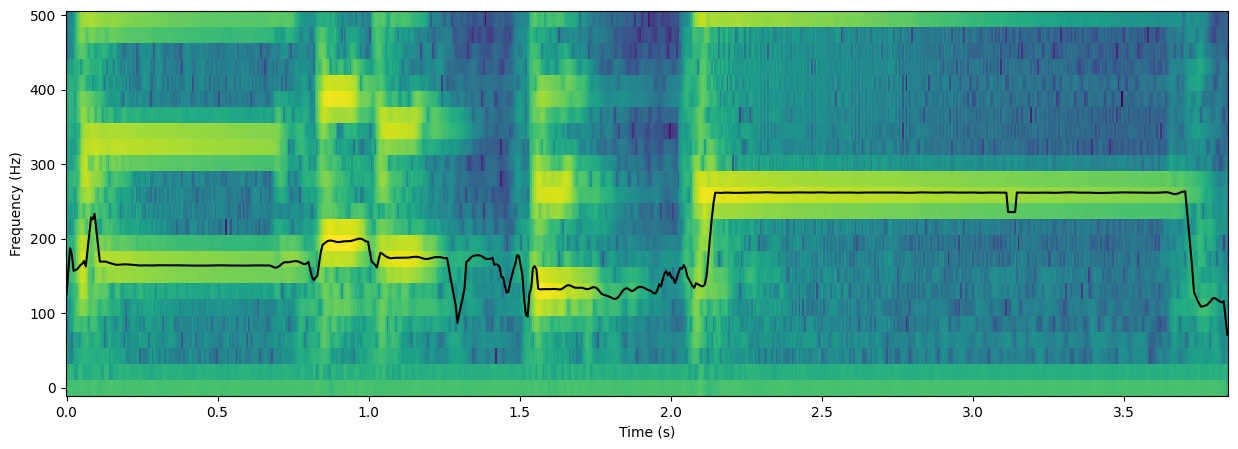

In [ ]:


### modify anything

input_file = 'piano.wav'
window = 'hamming'
M = 2048
N = 2048
H = 256
f0et = 5.0
t = -100
minf0 = 100
maxf0 = 300

ipd.display(ipd.Audio('piano.wav'))
fs, x = UF.wavread(input_file)
w  = get_window(window, M)
f0 = f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)

## Code for plotting the f0 contour on top of the spectrogram
maxplotfreq = 500.0
plt.figure(figsize=(15, 5))

mX, pX = stft.stftAnal(x, w, N, H)
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])

timeStamps = np.arange(mX.shape[1])*H/float(fs)
binFreqs = np.arange(mX.shape[0])*fs/float(N)

plt.pcolormesh(timeStamps, binFreqs, mX, shading='auto')
plt.plot(timeStamps, f0, color = 'k', linewidth=1.5)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')


y = UF.sinewaveSynth(f0, 0.8, H, fs)
ipd.display(ipd.Audio(data=y, rate=fs))
    


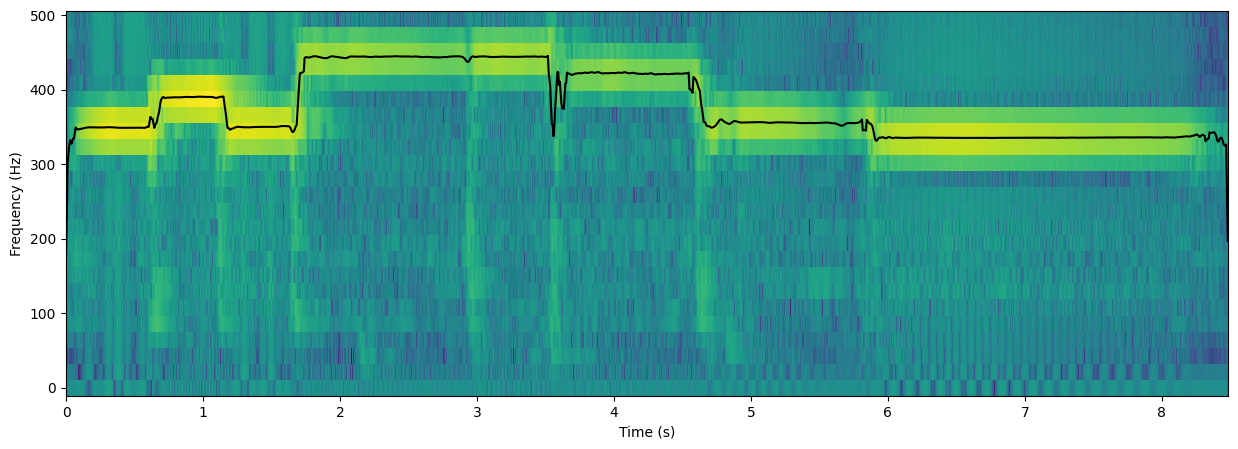

In [24]:
#CELLO

### modify anything

input_file = 'cello-phrase.wav'
stdThsld = 5
minNoteDur = 0.3
winStable = 4
window = 'hamming'
M = 2048
N = 2048
H = 256
f0et = 5
t = -100
minf0 = 250
maxf0 = 450

ipd.display(ipd.Audio('cello-phrase.wav'))
fs, x = UF.wavread(input_file)
w  = get_window(window, M)
f0 = f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)

## Code for plotting the f0 contour on top of the spectrogram
maxplotfreq = 500.0
plt.figure(figsize=(15, 5))

mX, pX = stft.stftAnal(x, w, N, H)
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])

timeStamps = np.arange(mX.shape[1])*H/float(fs)
binFreqs = np.arange(mX.shape[0])*fs/float(N)

plt.pcolormesh(timeStamps, binFreqs, mX, shading='auto')
plt.plot(timeStamps, f0, color = 'k', linewidth=1.5)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')


y = UF.sinewaveSynth(f0, 0.8, H, fs)
ipd.display(ipd.Audio(data=y, rate=fs))

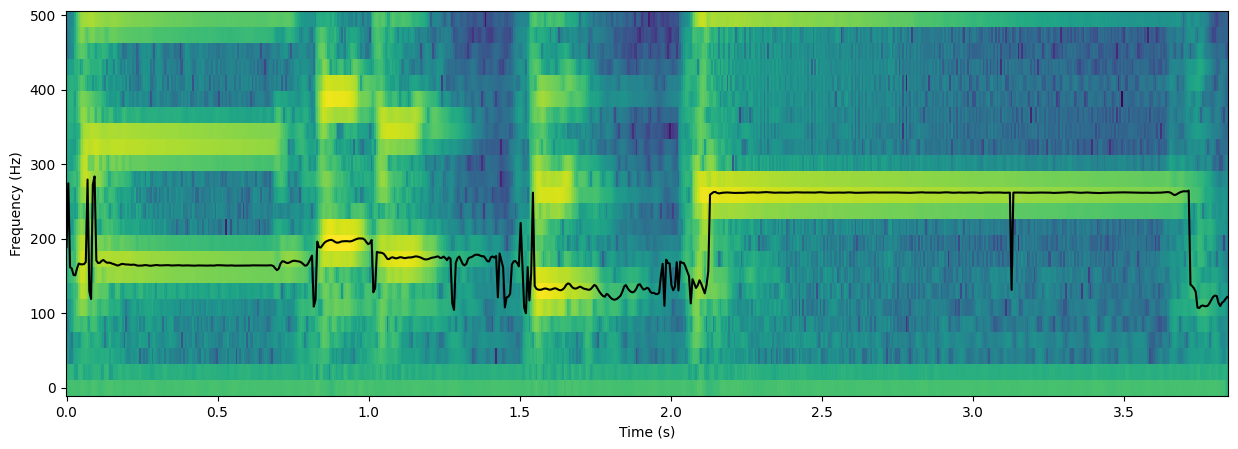

In [25]:

#Piano without the modifications

### modify anything

input_file = 'piano.wav'
window = 'hamming'
M = 2048
N = 2048
H = 256
f0et = 5.0
t = -100
minf0 = 100
maxf0 = 300

ipd.display(ipd.Audio('piano.wav'))
fs, x = UF.wavread(input_file)
w  = get_window(window, M)
f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)

## Code for plotting the f0 contour on top of the spectrogram
maxplotfreq = 500.0
plt.figure(figsize=(15, 5))

mX, pX = stft.stftAnal(x, w, N, H)
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])

timeStamps = np.arange(mX.shape[1])*H/float(fs)
binFreqs = np.arange(mX.shape[0])*fs/float(N)

plt.pcolormesh(timeStamps, binFreqs, mX, shading='auto')
plt.plot(timeStamps, f0, color = 'k', linewidth=1.5)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

y = UF.sinewaveSynth(f0, 0.8, H, fs)
ipd.display(ipd.Audio(data=y, rate=fs))

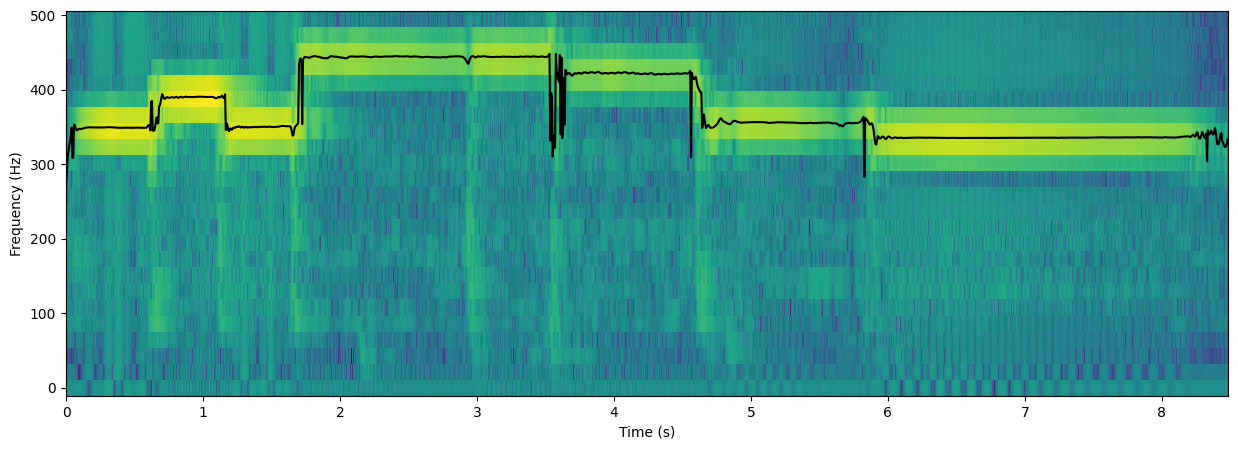

In [26]:
#Cello without the modifications

### modify anything

input_file = 'cello-phrase.wav'
stdThsld = 5
minNoteDur = 0.3
winStable = 4
window = 'hamming'
M = 2048
N = 2048
H = 256
f0et = 5
t = -100
minf0 = 250
maxf0 = 450

ipd.display(ipd.Audio('cello-phrase.wav'))
fs, x = UF.wavread(input_file)
w  = get_window(window, M)
f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)

## Code for plotting the f0 contour on top of the spectrogram
maxplotfreq = 500.0
plt.figure(figsize=(15, 5))

mX, pX = stft.stftAnal(x, w, N, H)
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])

timeStamps = np.arange(mX.shape[1])*H/float(fs)
binFreqs = np.arange(mX.shape[0])*fs/float(N)

plt.pcolormesh(timeStamps, binFreqs, mX, shading='auto')
plt.plot(timeStamps, f0, color = 'k', linewidth=1.5)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

y = UF.sinewaveSynth(f0, 0.8, H, fs)
ipd.display(ipd.Audio(data=y, rate=fs))



To improve the fundamental frequency (f0) estimation, I implemented several modifications:

Smoothing the f0 Contour:
One of the key issues observed was the presence of abrupt changes in the estimated f0, which made the results less stable. To address this, I applied a moving average filter to smooth the f0 trajectory. This reduces high-frequency fluctuations and provides a cleaner, more continuous estimation over time.

Adding Harmonic Candidates:
In many cases, especially for low-pitched sounds, the fundamental frequency component is weak or even missing due to energy roll-off or recording conditions. Since the TWM algorithm relies on detected spectral peaks as f0 candidates, this can lead to inaccurate estimations. To mitigate this issue, I introduced harmonic candidates by considering integer multiples of the detected peaks. This increases the chances of correctly identifying f0, especially in signals where the fundamental is not prominent.

Allowing Tolerance for Harmonic Deviations:
Many real-world sounds, such as those produced by pianos and other complex instruments, do not have perfectly harmonic frequency relationships. Slight deviations from integer multiples are common. To make the algorithm more robust, I introduced a tolerance factor that allows small deviations in harmonic alignment. This helps the TWM algorithm track the f0 more reliably, even when harmonics are slightly shifted due to inharmonicity.

The plots and audio comparisons clearly show that the applied improvements enhance f0 estimation, resulting in a smoother and more accurate fundamental frequency trajectory.